In [1]:
import numpy as np
from scipy.interpolate import griddata
from matplotlib import pyplot as plt
import torch

import sys
sys.path.append('..')
from fnn import FNN
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device={device}')

/home/zchen/install/envs/cuda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device=cuda


In [2]:
u0 = np.loadtxt('./wavefield2d_t0.txt')
u1 = np.loadtxt('./wavefield2d_t1.txt')

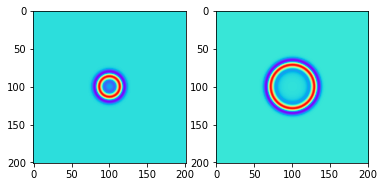

In [3]:
plt.subplot(121)
plt.imshow(u0, cmap='rainbow')
plt.subplot(122)
plt.imshow(u1, cmap='rainbow')

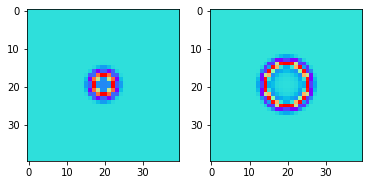

In [4]:
# Grid
nx = nz = 200
h = 0.01
xmax = nx * h
zmax = nz * h

xx, zz = np.meshgrid(np.arange(nx+1)*h, np.arange(nz+1)*h)
xx = xx.flatten()[:, np.newaxis]
zz = zz.flatten()[:, np.newaxis]
X = np.c_[xx, zz]

# Initial data
num_init = 40# number of initial data per time snapshot is n_init^2
x_init, z_init = np.meshgrid(np.linspace(0, xmax, num_init), np.linspace(0, zmax, num_init))
X_init = np.c_[x_init.flatten()[:, np.newaxis], z_init.flatten()[:, np.newaxis]] 

t1 = 0.0
t2 = 0.1
# t1 
t_init1 = t1 * np.ones((num_init**2, 1))
TX_init1 = np.c_[t_init1, X_init]
U_init1 = griddata(X, u0.flatten(), X_init, fill_value=0.0)[:, np.newaxis] # interpolate wavefield
# t2
t_init2 = t2 * np.ones((num_init**2, 1))
TX_init2 = np.c_[t_init2, X_init]
U_init2 = griddata(X, u1.flatten(), X_init, fill_value=0.0)[:, np.newaxis] # interpolate wavefield

TX_init = np.r_[TX_init1, TX_init2]
U_init = np.r_[U_init1, U_init2]

plt.subplot(121)
plt.imshow(U_init1.reshape(num_init, num_init), cmap='rainbow')
plt.subplot(122)
plt.imshow(U_init2.reshape(num_init, num_init), cmap='rainbow')

In [5]:
uscl = np.abs(U_init1).max()

TX_init[:, 1:2] /= 2
TX_init[:, 2:3] /= 2
TX_init = torch.tensor(TX_init, dtype=torch.float64, device=device)
U_init = torch.tensor(U_init/uscl, dtype=torch.float64, device=device)


TX_init1[:, 1:2] /= 2
TX_init1[:, 2:3] /= 2
TX_init1 = torch.tensor(TX_init1, dtype=torch.float64, device=device)
U_init1 = torch.tensor(U_init1/uscl, dtype=torch.float64, device=device)


TX_init2[:, 1:2] /= 2
TX_init2[:, 2:3] /= 2
TX_init2 = torch.tensor(TX_init2, dtype=torch.float64, device=device)
U_init2 = torch.tensor(U_init2/uscl, dtype=torch.float64, device=device)

In [6]:
layer_sizes = [3]+[30]*3+[1]
network = FNN(layer_sizes).to(torch.float64).to(device)

lr = 1e-4
optimizer = torch.optim.Adam(network.parameters(), lr=lr) 

In [13]:
def loss1():
    U1= network(TX_init1)
    loss_val = torch.mean(torch.square(U1 - U_init1))
    error_val = torch.linalg.norm(U1 - U_init1) / torch.linalg.norm(U_init1)
    return loss_val, error_val
def loss2():
    U2 = network(TX_init2)
    loss_val = torch.mean(torch.square(U2 - U_init2))
    error_val = torch.linalg.norm(U2 - U_init2) / torch.linalg.norm(U_init2)
    return loss_val, error_val

def loss():
    U = network(TX_init)
    loss_val = torch.mean(torch.square(U - U_init))
    error_val = torch.linalg.norm(U - U_init) / torch.linalg.norm(U_init)
    return loss_val, error_val

In [16]:
loss_list = list()
error_list = list()
def train():
    max_epoch = 200000
    interval = 1000
    for num_epoch in range(max_epoch):
        loss_val, error_val = loss()
        # loss_val, error_val = loss1()
        # loss_val, error_val = loss2()
        loss_list.append(loss_val.item())
        error_list.append(error_val.item())
        
        if num_epoch % interval == 0:
            print('Epoch: ', num_epoch, f"Loss: {loss_val.item():.8f}", f"Error: {error_val.item():.8f}")
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

In [17]:
train()

Epoch:  0 Loss: 0.01217484 Error: 1.01638103
Epoch:  1000 Loss: 0.01178540 Error: 0.99999323
Epoch:  2000 Loss: 0.01178518 Error: 0.99998389
Epoch:  3000 Loss: 0.01178512 Error: 0.99998122
Epoch:  4000 Loss: 0.01178513 Error: 0.99998156
Epoch:  5000 Loss: 0.01178503 Error: 0.99997757
Epoch:  6000 Loss: 0.01178500 Error: 0.99997612
Epoch:  7000 Loss: 0.01178497 Error: 0.99997474
Epoch:  8000 Loss: 0.01178493 Error: 0.99997333
Epoch:  9000 Loss: 0.01178490 Error: 0.99997180
Epoch:  10000 Loss: 0.01178485 Error: 0.99997000
Epoch:  11000 Loss: 0.01178480 Error: 0.99996770
Epoch:  12000 Loss: 0.01178472 Error: 0.99996444
Epoch:  13000 Loss: 0.01178464 Error: 0.99996075
Epoch:  14000 Loss: 0.01178436 Error: 0.99994882
Epoch:  15000 Loss: 0.01178389 Error: 0.99992905
Epoch:  16000 Loss: 0.01178332 Error: 0.99990471
Epoch:  17000 Loss: 0.01178286 Error: 0.99988528
Epoch:  18000 Loss: 0.01178237 Error: 0.99986478
Epoch:  19000 Loss: 0.01178171 Error: 0.99983643
Epoch:  20000 Loss: 0.01178062 Er

Epoch:  167000 Loss: 0.00000312 Error: 0.01626263
Epoch:  168000 Loss: 0.00000312 Error: 0.01626626
Epoch:  169000 Loss: 0.00000306 Error: 0.01611849
Epoch:  170000 Loss: 0.00000303 Error: 0.01604088
Epoch:  171000 Loss: 0.00000302 Error: 0.01599604
Epoch:  172000 Loss: 0.00000298 Error: 0.01589184
Epoch:  173000 Loss: 0.00000295 Error: 0.01581943
Epoch:  174000 Loss: 0.00000292 Error: 0.01575160
Epoch:  175000 Loss: 0.00000291 Error: 0.01571262
Epoch:  176000 Loss: 0.00000287 Error: 0.01561597
Epoch:  177000 Loss: 0.00000285 Error: 0.01554439
Epoch:  178000 Loss: 0.00000287 Error: 0.01560981
Epoch:  179000 Loss: 0.00000280 Error: 0.01542019
Epoch:  180000 Loss: 0.00000278 Error: 0.01534926
Epoch:  181000 Loss: 0.00000276 Error: 0.01531154
Epoch:  182000 Loss: 0.00000286 Error: 0.01558825
Epoch:  183000 Loss: 0.00000271 Error: 0.01516334
Epoch:  184000 Loss: 0.00000290 Error: 0.01569867
Epoch:  185000 Loss: 0.00000267 Error: 0.01505118
Epoch:  186000 Loss: 0.00000277 Error: 0.01532524


Text(0.5, 1.0, 'Error')

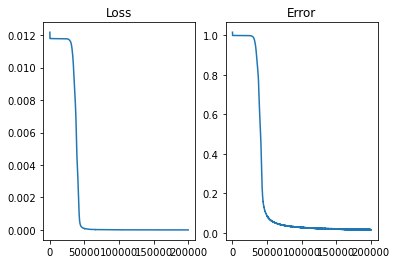

In [18]:
plt.subplot(121)
plt.plot(loss_list, label='loss')
plt.title('Loss')
plt.subplot(122)
plt.plot(error_list, label='error')
plt.title('Error')

In [19]:
def predict(TX):
    # TX = torch.tensor(TX, dtype=torch.float64, device=device)
    u_pred = network(TX).detach().cpu().numpy()
    return u_pred

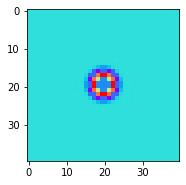

In [20]:
U_pred1 = predict(TX_init1).reshape(num_init, num_init)
plt.subplot(121)
plt.imshow(U_pred1.reshape(num_init, num_init), cmap='rainbow')

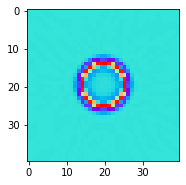

In [21]:
U_pred2 = predict(TX_init2).reshape(num_init, num_init)
plt.subplot(122)
plt.imshow(U_pred2.reshape(num_init, num_init), cmap='rainbow')

In [2]:
# test model 
model = torch.load('model.pt')

In [4]:
## ---------------------- 1. Data Preprocess---------------------------------------------------
h = 0.01 # km
dt = 0.001 # s
nx = nz = 200 
xmax = h * nx 
zmax = h * nz

nt1 = 200
nt2 = 300
nt3 = 500
nt4 = 850
t1 = 0.0
t2 = (nt2 - nt1) * dt 
t3 = (nt3 - nt1) * dt 
t4 = (nt4 - nt1) * dt 

# Load data 
u = list()
for i in range(4):
    data = np.loadtxt('./wavefield2d_t' + str(i) + '.txt')
    u.append(data)

# Grid
xx, zz = np.meshgrid(np.arange(nx+1)*h, np.arange(nz+1)*h)
xx = xx.flatten()[:, np.newaxis]
zz = zz.flatten()[:, np.newaxis]
X = np.c_[xx, zz]

# Initial data
num_init = 40 # number of initial data per time snapshot is n_init^2
x_init, z_init = np.meshgrid(np.linspace(0, xmax, num_init), np.linspace(0, zmax, num_init))
X_init = np.c_[x_init.flatten()[:, np.newaxis], z_init.flatten()[:, np.newaxis]] 
# t1 
t_init1 = t1 * np.ones((num_init**2, 1))
TX_init1 = np.c_[t_init1, X_init]
U_init1 = griddata(X, u[0].flatten(), X_init)[:, np.newaxis] # interpolate wavefield
# t2
t_init2 = t2 * np.ones((num_init**2, 1))
TX_init2 = np.c_[t_init2, X_init]
U_init2 = griddata(X, u[1].flatten(), X_init)[:, np.newaxis] # interpolate wavefield

TX_init = np.r_[TX_init1, TX_init2]
U_init = np.r_[U_init1, U_init2]

# Test data
# t3 
t_init3 = t3 * np.ones((num_init**2, 1))
TX_init3 = np.c_[t_init3, X_init]
U_init3 = griddata(X, u[2].flatten(), X_init)[:, np.newaxis] # interpolate wavefield
# t2
t_init4 = t4 * np.ones((num_init**2, 1))
TX_init4 = np.c_[t_init4, X_init]
U_init4 = griddata(X, u[3].flatten(), X_init)[:, np.newaxis] # interpolate wavefield

TX_test = np.r_[TX_init3, TX_init4]
U_test = np.r_[U_init3, U_init4]

In [5]:
uscl = np.abs(U_init).max()
uscl

3.5035848498288275e-06

In [8]:
def predict(TX):
    TX = torch.tensor(TX, dtype=torch.float64, device=device)
    U_pred = model(TX).detach().cpu().numpy()
    return U_pred * uscl

def error(U_pred, U_test):
    assert U_pred.shape == U_test.shape
    error_val = np.linalg.norm(U_pred - U_test) / np.linalg.norm(U_test)
    return error_val

In [9]:
U_pred1 = predict(TX_init1)
error(U_pred1, U_init1)

0.013569165753698039

In [10]:
U_pred2 = predict(TX_init2)
error(U_pred2, U_init2)

0.022250127684804704

In [11]:
U_pred3 = predict(TX_init3)
error(U_pred3, U_init3)

1.4364282088461622

In [12]:
U_pred4 = predict(TX_init4)
error(U_pred4, U_init4)

0.12153883092920306

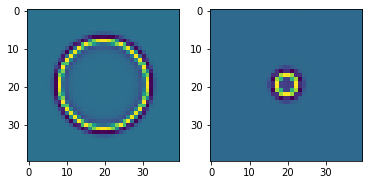

In [13]:
plt.subplot(121)
plt.imshow(U_init3.reshape(num_init, num_init))
plt.subplot(122)
plt.imshow(U_pred3.reshape(num_init, num_init))

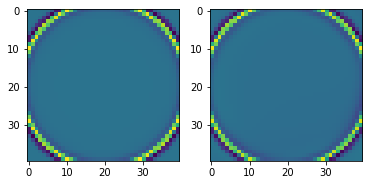

In [14]:
plt.subplot(121)
plt.imshow(U_init4.reshape(num_init, num_init))
plt.subplot(122)
plt.imshow(U_pred4.reshape(num_init, num_init))

In [15]:
TX_init3[:, 0:1].max(), TX_init3[:, 0:1].min() 

(0.0, 0.0)

In [16]:
t3

0.3

In [17]:
len(X)

40401

In [21]:
t_pred = t4 * np.ones((len(X), 1))
TX_pred = np.c_[t_pred, X]
U_pred = predict(TX_pred)

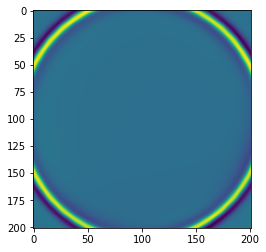

: 

In [22]:
plt.imshow(U_pred.reshape(201, 201))